In [4]:
import random
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import numpy
from scipy.stats import multinomial
from scipy.stats import binom

from scipy.stats import poisson
import math

'''
The multinomial CDF function is the implementation of Levin's "Representaion of Multinomial Cumulative Distribution Function"

G:= Number of total groups (including non-protected)
k:= Position
p:= Array of probabilities of each group to be selected
tau_p:= Array of number of protected items

EXAMPLE:
Groups: ["White"(NP), "Black"(P), "Asian"(P), "Hispanic"(P)]
k: 30
p: [0.4, 0.3, 0.2, 0.1]
tau_p: [k, 10, 5, 3]
The ranking is fair if multinomCDF(4, 30, p, tau_p) > a = 0.1 
'''

def multinomCDF_log(G, k, p, tau_p):
    s = float(k);
    log_cdf = -poisson.logpmf(k,s);
    gamma1 = 0.0;
    gamma2 = 0.0;
    sum_s2 = 0.0;
    sum_mu = 0.0;
    
    # P(W=k)
    for i in range(0,G):
        sp = s*p[i];
        
        pcdf = poisson.cdf(tau_p[i],sp);
        log_cdf += numpy.log(pcdf);
        
        mu = sp*(1-poisson.pmf(tau_p[i],sp)/pcdf);
        s2 = mu-(tau_p[i]-mu)*(sp-mu);
        
        mr = tau_p[i];
        mf2 = sp*mu-mr*(sp-mu);
        
        mr *= tau_p[i]-1;
        mf3 = sp*mf2-mr*(sp-mu);
        
        mr *= tau_p[i]-2;
        mf4 = sp*mf3-mr*(sp-mu);
        
        mu2 = mf2+mu*(1-mu);
        mu3 = mf3+mf2*(3-3*mu)+mu*(1+mu*(-3+2*mu));
        mu4 = mf4+mf3*(6-4*mu)+mf2*(7+mu*(-12+6*mu))+mu*(1+mu*(-4+mu*(6-3*mu)));
        
        gamma1 += mu3;
        gamma2 += mu4-3*s2*s2;
        sum_mu += mu;
        sum_s2 += s2; 
    sp = numpy.sqrt(sum_s2);
    gamma1 /= sum_s2*sp;
    gamma2 /= sum_s2*sum_s2;
    
    x = (k-sum_mu)/sp;
    x2 = x*x;
    
    PWN = (-x2/2
    +numpy.log(1+gamma1/6*x*(x2-3)+gamma2/24*(x2*x2-6*x2+3)
    +gamma1*gamma1/72*(((x2-15)*x2+45)*x2-15))
    -numpy.log(2*math.pi)/2 -numpy.log(sp));
    
    log_cdf += PWN;
    return log_cdf;

def multinomCDF(G, k, p, tau_p):
    return numpy.exp(multinomCDF_log(G, k, p, tau_p ));
          

In [5]:
import copy

"""
To get a random multinomial icdf value from a solution space.
For the Ranking Algorithm, it cannot be used because the solutions are not continuous.
"""
def multinomial_icdf(G, k, p, a):
#     tau_p = [k] + list((numpy.round(numpy.array(p)*k))[1:]);
    tau_p = [k] + list(((numpy.array(p)*k).astype(int))[1:]);
    temp = copy.copy(tau_p)
    i = 1;
    cdf = multinomCDF(G, k, p, tau_p)
    found = 0
    while(found == 0):
        if(cdf > a):
            temp[i] = temp[i]-1;
            if(multinomCDF(G, k, p, temp) > a):
                tau_p = copy.copy(temp);
                cdf = multinomCDF(G, k, p, tau_p)
            else:
                found = 1;
  
        elif(cdf < a):
            temp[i] = temp[i]+1;
            if(multinomCDF(G, k, p, temp) < a):
                tau_p = copy.copy(temp);
                cdf = multinomCDF(G, k, p, tau_p)
            else:
                tau_p[i] = tau_p[i]+1;
                cdf = multinomCDF(G, k, p, tau_p)
                found = 1;    
        else:
            found = 1
        if(i == (len(tau_p)-1)):
            i = 1;
        else:
            i = i+1;
    return tau_p


"""
To find a continuous multinomial icdf solution from a solution space.
Used for the Ranking Algorithm.
If the multinomial_CDF with tau alreay results in the value > a, return tau.
Else calculate the multinomial_CDF of tau in each case when each element of tau is increased by 1.
Compare the value and take the tau that produces the closest multinomial_CDF to a, which is also > a.

For example, initial tau: [0, 0, 0, 0]
if: 
    multinomial_CDF(G, k, p, tau) > a, return tau
else:
    compare:
        multinomial_CDF(G, k, p, [1, 0, 0, 0])
        multinomial_CDF(G, k, p, [0, 1, 0, 0])
        multinomial_CDF(G, k, p, [0, 0, 1, 0])
        multinomial_CDF(G, k, p, [0, 0, 0, 1])
    and take the increased tau with its multinomial_CDF > a and closest to a    

"""
def multinomial_icdf_continuous(G, k, p, a, tau):
    tau_p = [k] + list(tau);
    temp = copy.copy(tau_p)
    cdf = multinomCDF(G, k, p, tau_p)
    new_cdf = 0;
    initial = 1;
    not_fulfilled = 0;
    
    if(cdf > a):
        return tau_p;
    for i in range(len(tau_p)-1):
        temp[i+1] = temp[i+1]+1;
        if(initial == 1):
            tau_p = copy.copy(temp);
            cdf = multinomCDF(G, k, p, tau_p);
            initial = 0;
        else:
            new_cdf = multinomCDF(G, k, p, temp)
            if(new_cdf >= a and new_cdf >= cdf):
                tau_p = copy.copy(temp);
                cdf = multinomCDF(G, k, p, tau_p); 
        if(new_cdf >= a or cdf >= a):
            if(not_fulfilled == 1):
                tau_p = copy.copy(temp);
                not_fulfilled = 0;
            else:
                temp[i+1] = temp[i+1]-1
                not_fulfilled = 0
        else:
            not_fulfilled = 1
    return tau_p

"""
Finds the target group which does not achieve the minimum target.
"""
def find_target(least_items, count, groups):
    for i in least_items:
        for j in range(len(i)):
            if(i[j] > count[j+1]):
                return groups[j+1];

In [6]:
import pandas as pd
"""
Example Case for Ranking Algorithm without considering the quality

Non-protected: White
Protected: Black, Asian, Hispanic, Half
"""

# races = ['White', 'Black', 'Asian', 'Hispanic', 'Half'];
# p = [0.4, 0.2, 0.2, 0.1, 0.1];

races = ['White', 'Black', 'Asian', 'Hispanic'];
p = [0.4, 0.3, 0.2, 0.1];
a = 0.1;
k = 100;
positions = numpy.array(list(range(k))) + 1;
# prob = (numpy.array(list(range(8)))+1)/10.0;
least_items = [];
"""
tau is used for the multinomial_icdf_continuous. 
Initialized as an array of zeros with its length identical with the number of protected groups.
For this example, therefore tau=[0.0, 0.0, 0.0, 0.0]
"""
tau = numpy.zeros(len(races)-1);

# for i in positions:
#     tau_p = multinomial_icdf(len(p), i, p , a)[1:]
#     least_items.append(numpy.array(tau_p));

for i in positions:
    tau_p = multinomial_icdf_continuous(len(p), i, p , a, tau)[1:]
    least_items.append(numpy.array(tau_p));
    tau = copy.copy(tau_p);

# for i in range (k):
#     print i+1,"  : ",least_items[i];
#     test = numpy.append([i+1],least_items[i])
#     print "CDF: ",multinomCDF(4, i+1, p, test)
#     test = []
# print"------------------------------------"    
# multinomial_icdf_continuous(len(p), 5, p , a, [0,0,1,2])[1:]
for i in range (k):
    print i+1,"  : ",least_items[i];
    test = numpy.append([i+1],least_items[i])
    print "CDF: ",multinomCDF(4, i+1, p, test)
    test = []


1   :  [ 0.  0.  0.]
CDF:  0.489076210108
2   :  [ 0.  0.  0.]
CDF:  0.143143629273
3   :  [ 1.  0.  0.]
CDF:  0.215406326187
4   :  [ 1.  0.  0.]
CDF:  0.102354298793
5   :  [ 1.  1.  0.]
CDF:  0.156660082998
6   :  [ 2.  1.  0.]
CDF:  0.191685274651
7   :  [ 2.  1.  0.]
CDF:  0.113512148742
8   :  [ 2.  1.  1.]
CDF:  0.155038457835
9   :  [ 2.  2.  1.]
CDF:  0.195757722599
10   :  [ 2.  2.  1.]
CDF:  0.125165180181
11   :  [ 3.  2.  1.]
CDF:  0.170767725836
12   :  [ 3.  2.  1.]
CDF:  0.111786383426
13   :  [ 4.  2.  1.]
CDF:  0.134509535933
14   :  [ 4.  3.  1.]
CDF:  0.16691448429
15   :  [ 4.  3.  1.]
CDF:  0.11558676158
16   :  [ 4.  3.  2.]
CDF:  0.141931327409
17   :  [ 5.  3.  2.]
CDF:  0.175483017642
18   :  [ 5.  3.  2.]
CDF:  0.125712325186
19   :  [ 5.  4.  2.]
CDF:  0.153235882103
20   :  [ 5.  4.  2.]
CDF:  0.110063115075
21   :  [ 6.  4.  2.]
CDF:  0.136791879392
22   :  [ 7.  4.  2.]
CDF:  0.155096312266
23   :  [ 7.  4.  2.]
CDF:  0.115363213039
24   :  [ 7.  5.  2.]


In [16]:
multinomCDF(6, 20, [1.0/6,1.0/6,1.0/6,1.0/6,1.0/6,1.0/6], [4,3,4,4,3,2])

0.00090015701390091824

In [11]:
import pandas as pd

races = ['M', 'D', 'S', 'W'];
p = [0.6, 0.15, 0.15, 0.1];
a = 0.1;
k = 20;
positions = numpy.array(list(range(k))) + 1;
# prob = (numpy.array(list(range(8)))+1)/10.0;
least_items = [];
tau = numpy.zeros(len(races)-1);

for i in positions:
    tau_p = multinomial_icdf_continuous(len(p), i, p , a, tau)[1:]
    least_items.append(numpy.array(tau_p));
    tau = copy.copy(tau_p);

for i in range (k):
    print i+1,"  : ",least_items[i];
    test = numpy.append([i+1],least_items[i])
    print "CDF: ",multinomCDF(4, i+1, p, test)
    test = []

1   :  [ 0.  0.  0.]
CDF:  0.711585893025
2   :  [ 0.  0.  0.]
CDF:  0.337311825243
3   :  [ 0.  0.  0.]
CDF:  0.182083592238
4   :  [ 0.  0.  0.]
CDF:  0.102549864356
5   :  [ 0.  1.  0.]
CDF:  0.162085978178
6   :  [ 0.  1.  0.]
CDF:  0.106279978475
7   :  [ 1.  1.  0.]
CDF:  0.196836075238
8   :  [ 1.  1.  0.]
CDF:  0.140031468166
9   :  [ 1.  1.  1.]
CDF:  0.232317650539
10   :  [ 1.  1.  1.]
CDF:  0.172903868198
11   :  [ 1.  1.  1.]
CDF:  0.126734621051
12   :  [ 1.  2.  1.]
CDF:  0.175683110725
13   :  [ 1.  2.  1.]
CDF:  0.133443718936
14   :  [ 1.  2.  1.]
CDF:  0.100052170874
15   :  [ 2.  2.  1.]
CDF:  0.160201810241
16   :  [ 2.  2.  1.]
CDF:  0.123867647138
17   :  [ 2.  2.  2.]
CDF:  0.167238975054
18   :  [ 2.  2.  2.]
CDF:  0.131716639247
19   :  [ 2.  2.  2.]
CDF:  0.102607097181
20   :  [ 2.  3.  2.]
CDF:  0.140996704876


In [38]:
multinomCDF(4, 13, p, [13,3,2,0])

0.13224833387769291

In [7]:
rank = [];
count = [0,0,0,0];
random_choice = "";
chosen = 0;
num = 1;
swap = 0;
target = "";
for i in least_items:
    for j in range(len(i)):
        if(i[j] > count[j+1] and chosen == 0):
            rank.append(races[j+1]);
            print "chosen", races[j+1];
            count[j+1] += 1;
            chosen = 1;
            if(any(count[a+1]<i[a] for a in range(len(i)))):
                swap = len(rank)-1;
                print"-------------------------------------------"
                while(any(count[a+1]<i[a] for a in range(len(i)))):
                    target = find_target(least_items, count, races);
                    if(rank[swap] == races[0]):
                        rank[swap] = target;
                        print "swap",rank[swap];
                        print "count before", count
                        count[races.index(target)] += 1;
                        count[0] -= 1;
                        print "count after",count
                        print "swap index",swap
                    swap -= 1;    
                        
            print "Minimum achieved? ", all(count[a+1]>=i[a] for a in range(len(i)))
    if(chosen == 0):
        random_choice = numpy.random.choice(races, 1, p=p);
        print random_choice;
        rank.append(random_choice[0]);
        count[races.index(random_choice)] += 1;
    print num, ": ", count;
    num = num+1;
    chosen = 0;             

['S']
1 :  [0, 0, 1, 0]
['W']
2 :  [0, 0, 1, 1]
['M']
3 :  [1, 0, 1, 1]
['D']
4 :  [1, 1, 1, 1]
['S']
5 :  [1, 1, 2, 1]
['M']
6 :  [2, 1, 2, 1]
['M']
7 :  [3, 1, 2, 1]
['M']
8 :  [4, 1, 2, 1]
['M']
9 :  [5, 1, 2, 1]
['M']
10 :  [6, 1, 2, 1]
['M']
11 :  [7, 1, 2, 1]
['S']
12 :  [7, 1, 3, 1]
['M']
13 :  [8, 1, 3, 1]
['W']
14 :  [8, 1, 3, 2]
chosen D
Minimum achieved?  True
15 :  [8, 2, 3, 2]
['W']
16 :  [8, 2, 3, 3]
['W']
17 :  [8, 2, 3, 4]
['W']
18 :  [8, 2, 3, 5]
['M']
19 :  [9, 2, 3, 5]
['S']
20 :  [9, 2, 4, 5]


In [6]:
for i in range(len(rank)):
    print "k =",i+1,": ",rank[i]     

k = 1 :  White
k = 2 :  Asian
k = 3 :  Black
k = 4 :  Hispanic
k = 5 :  Hispanic
k = 6 :  Black
k = 7 :  White
k = 8 :  Black
k = 9 :  Asian
k = 10 :  Hispanic
k = 11 :  Black
k = 12 :  White
k = 13 :  Black
k = 14 :  Asian
k = 15 :  White
k = 16 :  White
k = 17 :  White
k = 18 :  White
k = 19 :  Asian
k = 20 :  Asian
k = 21 :  Black
k = 22 :  Black
k = 23 :  Black
k = 24 :  Asian
k = 25 :  Black
k = 26 :  White
k = 27 :  Black
k = 28 :  White
k = 29 :  White
k = 30 :  Asian
k = 31 :  Black
k = 32 :  Hispanic
k = 33 :  White
k = 34 :  Black
k = 35 :  Asian
k = 36 :  White
k = 37 :  White
k = 38 :  Black
k = 39 :  White
k = 40 :  Black
k = 41 :  Black
k = 42 :  Hispanic
k = 43 :  Asian
k = 44 :  Hispanic
k = 45 :  White
k = 46 :  Hispanic
k = 47 :  White
k = 48 :  White
k = 49 :  Asian
k = 50 :  White
k = 51 :  White
k = 52 :  Black
k = 53 :  Black
k = 54 :  Asian
k = 55 :  Black
k = 56 :  White
k = 57 :  Asian
k = 58 :  White
k = 59 :  Black
k = 60 :  White
k = 61 :  White
k = 62 :  Hi

In [7]:
"""
Read Data set (.json), saves as array of dictionaries of items
"""
import pandas as pd
import json
import ast

json_data = open('./test_data_sets_for_ipynb/test_data_set_500.json').read()
data = numpy.array(json_data.split("\n"))
data_set = []
for i in data:
    data_set.append(ast.literal_eval(i))
attribute = {"Gender": 4}   
data_set

[{'Gender': 0, 'Uni score': 0.5344585435},
 {'Gender': 2, 'Uni score': 1.0160173543},
 {'Gender': 0, 'Uni score': 0.4573686375},
 {'Gender': 1, 'Uni score': 0.6513702354},
 {'Gender': 1, 'Uni score': 0.5683681534},
 {'Gender': 3, 'Uni score': 0.7767882583},
 {'Gender': 1, 'Uni score': 0.5720163193},
 {'Gender': 0, 'Uni score': 0.3646469529},
 {'Gender': 0, 'Uni score': 0.4648817221},
 {'Gender': 0, 'Uni score': 0.5350985713},
 {'Gender': 2, 'Uni score': 1.1770626574},
 {'Gender': 3, 'Uni score': -0.670887751},
 {'Gender': 0, 'Uni score': 0.216323686},
 {'Gender': 2, 'Uni score': 1.5137061267},
 {'Gender': 0, 'Uni score': 0.4795152902},
 {'Gender': 1, 'Uni score': 0.8011014761},
 {'Gender': 2, 'Uni score': 1.1606679187},
 {'Gender': 3, 'Uni score': 1.0495726362},
 {'Gender': 3, 'Uni score': 0.309442046},
 {'Gender': 2, 'Uni score': 1.1198528938},
 {'Gender': 3, 'Uni score': 1.5733224326},
 {'Gender': 1, 'Uni score': 0.3624285705},
 {'Gender': 2, 'Uni score': 1.3079964314},
 {'Gender': 3

In [27]:
 """
    - data_set: list of items in dictionary form, which specifies its group and quality
        ex) 
        [{'Gender': 0, 'Uni score': 0.5344585435},
         {'Gender': 2, 'Uni score': 1.0160173543},
         {'Gender': 0, 'Uni score': 0.4573686375},
         {'Gender': 1, 'Uni score': 0.6513702354}]
         
    - attributeNamesAndCategories: attributes that are being used to specify groups in the data_set and its number of categories
        ex)
        {"Gender": 4}
    
    - attributeQuality: the name of the attribute used for quality
        ex)
        "Uni score"
        
    - k: total length of the ranking
    
    - p: array of prbability, that each group could be selected into the ranking
        ex)
        [0.4,0.3,0.2,0.1]
            -> 0.4 for Gender: 0 (Non-protected)
            -> 0.3 for Gender: 1 (Protected)
            -> 0.2 for Gender: 2 (Protected)
            -> 0.1 for Gender: 3 (Protected)
            
    - alpha: Percentage of Type I error        
        
    """

from operator import itemgetter, attrgetter, methodcaller
import itertools
import scipy.stats as stats
import pylab as pl

def get_num_categories(attributeNamesAndCategories):
    num_categories = 1
    for i in attributeNamesAndCategories.items():
        num_categories *= i[1]
    return num_categories    
    
def determineGroups(attributeNamesAndCategories):
    elementSets = []
    groups = []
    for attr, cardinality in attributeNamesAndCategories.items():
        elementSets.append(list(range(0, cardinality)))

    groups = list(itertools.product(*elementSets))
    return groups

def get_minimum_targets(categories, p, alpha, k):
    positions = numpy.array(list(range(k))) + 1;
    minimum_targets = [];
    tau = numpy.zeros(len(categories)-1);

    for i in positions:
        tau_p = multinomial_icdf_continuous(len(p), i, p , alpha, tau)[1:]
        minimum_targets.append(numpy.array(tau_p));
        tau = copy.copy(tau_p);
    return minimum_targets    

def separate_groups(data_set, categories, attributeItems):
    num_categories = len(categories)
    separateByGroups = [[] for _ in range(num_categories)]
    
    for i in data_set:
        categorieList = []
        for j in attributeItems:
            categorieList.append(i[j[0]])
        separateByGroups[categories.index(tuple(categorieList))].append(i)
        categorieList = []
    return separateByGroups    

def plot(data_set,attributeNamesAndCategories, attributeQuality):
    categories = determineGroups(attributeNamesAndCategories)
    attributeItems = attributeNamesAndCategories.items()
    output_ranking_separated = separate_groups(data_set,categories, attributeItems)
    separateQualityByGroups = []
    fig = plt.figure(figsize=(20, 10), dpi=100)
    for i in range(len(categories)):
        separateQualityByGroups.append([quality[attributeQuality] for quality in output_ranking_separated[i]])
        fit = stats.norm.pdf(separateQualityByGroups[i], numpy.mean(separateQualityByGroups[i]), numpy.std(separateQualityByGroups[i])) 
        pl.plot(separateQualityByGroups[i],fit,'-o', label="Group "+`i`)
        pl.hist(separateQualityByGroups[i],normed=True, label="Group "+`i`)
        
    pl.legend(loc='upper right', fontsize='x-large')
    pl.show()    
    
def generate_ranking(data_set, attributeNamesAndCategories, attributeQuality, k, p, alpha):
    index = 0
    categories = determineGroups(attributeNamesAndCategories)
    num_categories = len(categories)
    count = [0 for _ in range(num_categories)];
    ranking = []
    random_choice = ""
    chosen = 0
    num = 1
    swap = 0
    target = ""
    separateByGroups = [[] for _ in range(num_categories)]
    attributeItems = attributeNamesAndCategories.items()
    
    # Separate the groups into each list
    separateByGroups = separate_groups(data_set, categories, attributeItems)
    
    # Sort the items in ascending order of their quality
    for i in range(num_categories):
        separateByGroups[i] = sorted(separateByGroups[i], key=lambda item: item[attributeQuality]) 
    
    minimum_targets = get_minimum_targets(categories, p, alpha, k)
    
    for i in minimum_targets:
        for j in range(len(i)):
            if(i[j] > count[j+1] and chosen == 0):
                item = separateByGroups[j+1].pop()
                ranking.append(item)
                print "chosen", item
                count[j+1] += 1;
                chosen = 1;
                if(any(count[a+1]<i[a] for a in range(len(i)))):
#                     swap = len(rank)-1;
                    print"-------------------------------------------"
#                     while(any(count[a+1]<i[a] for a in range(len(i)))):
#                         target = find_target(least_items, count, races);
#                         if(rank[swap] == races[0]):
#                             rank[swap] = target;
#                             print "swap",rank[swap];
#                             print "count before", count
#                             count[races.index(target)] += 1;
#                             count[0] -= 1;
#                             print "count after",count
#                             print "swap index",swap
#                         swap -= 1;    

                print "Minimum achieved? ", all(count[a+1]>=i[a] for a in range(len(i)))
        if(chosen == 0):
            idx = numpy.random.choice(len(categories),1,p=p)[0]
            random_choice = categories[idx]
            item = separateByGroups[idx].pop()
            print item
            ranking.append(item);
            count[idx] += 1;
        print num, ": ", count, "Minimum Target: ",minimum_targets[num-1];
        print "CDF: ", multinomCDF(num_categories, num, p, [num]+count[1:])
        num = num+1;
        chosen = 0; 
    plot(ranking,attributeNamesAndCategories, attributeQuality)
    return ranking

[0.7887698602, 0.9564352348, 2.2329253232, 3.6487059175]
3
{'Gender': 3, 'Uni score': 3.6487059175}
1 :  [0, 0, 0, 1] Minimum Target:  [ 0.  0.  0.]
CDF:  0.571634877892
[0.7887698602, 0.9564352348, 2.2329253232, 2.5593864477]
3
{'Gender': 3, 'Uni score': 2.5593864477}
2 :  [0, 0, 0, 2] Minimum Target:  [ 0.  0.  0.]
CDF:  0.251891168098
chosen {'Gender': 1, 'Uni score': 0.9564352348}
Minimum achieved?  True
3 :  [0, 1, 0, 2] Minimum Target:  [ 1.  0.  0.]
CDF:  0.355734017739
[0.7887698602, 0.9368487783, 2.2329253232, 2.3762623133]
3
{'Gender': 3, 'Uni score': 2.3762623133}
4 :  [0, 1, 0, 3] Minimum Target:  [ 1.  0.  0.]
CDF:  0.216787986696
chosen {'Gender': 2, 'Uni score': 2.2329253232}
Minimum achieved?  True
5 :  [0, 1, 1, 3] Minimum Target:  [ 1.  1.  0.]
CDF:  0.345189442324
chosen {'Gender': 1, 'Uni score': 0.9368487783}
Minimum achieved?  True
6 :  [0, 2, 1, 3] Minimum Target:  [ 2.  1.  0.]
CDF:  0.447855048824
[0.7887698602, 0.9063713513, 2.1583313833, 2.371649435]
3
{'Gend

CDF:  0.496060240632
[0.7887698602, 0.6911401779, 1.3303467686, 1.3295651447]
2
{'Gender': 2, 'Uni score': 1.3303467686}
53 :  [0, 15, 22, 16] Minimum Target:  [ 15.  10.   6.]
CDF:  0.460349135169
[0.7887698602, 0.6911401779, 1.3276840567, 1.3295651447]
3
{'Gender': 3, 'Uni score': 1.3295651447}
54 :  [0, 15, 22, 17] Minimum Target:  [ 15.  11.   6.]
CDF:  0.425400232771
chosen {'Gender': 1, 'Uni score': 0.6911401779}
Minimum achieved?  True
55 :  [0, 16, 22, 17] Minimum Target:  [ 16.  11.   6.]
CDF:  0.507880547079
[0.7887698602, 0.6877514105, 1.3276840567, 1.3262787345]
2
{'Gender': 2, 'Uni score': 1.3276840567}
56 :  [0, 16, 23, 17] Minimum Target:  [ 16.  11.   6.]
CDF:  0.47302709458
chosen {'Gender': 1, 'Uni score': 0.6877514105}
Minimum achieved?  True
57 :  [0, 17, 23, 17] Minimum Target:  [ 17.  11.   6.]
CDF:  0.553474194678
[0.7887698602, 0.6805179616, 1.3079964314, 1.3262787345]
3
{'Gender': 3, 'Uni score': 1.3262787345}
58 :  [0, 17, 23, 18] Minimum Target:  [ 17.  11.  

/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:817: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bins


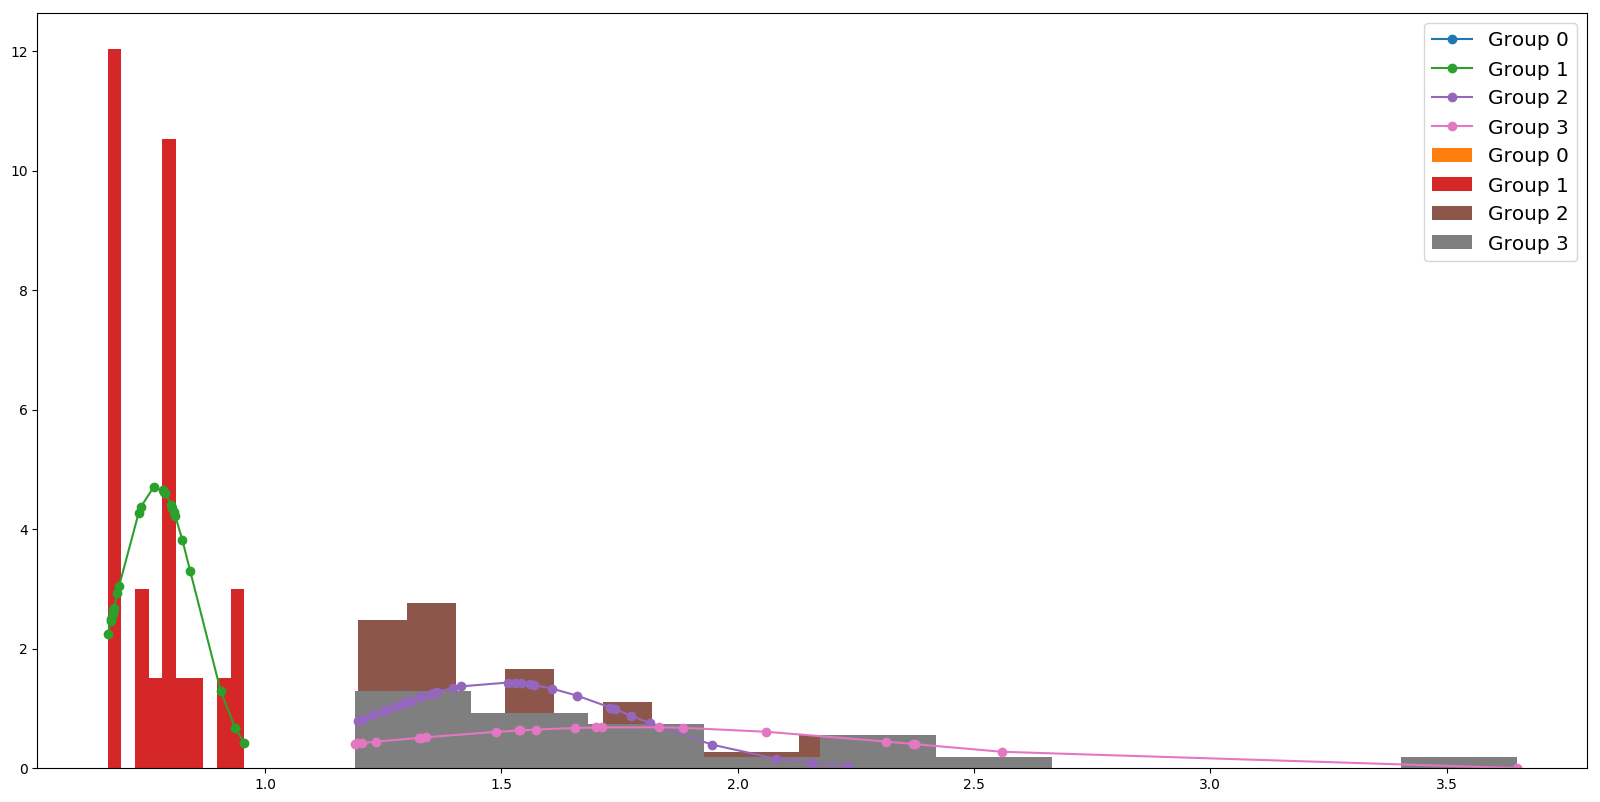

In [26]:
test_ranking = generate_ranking(data_set, attribute, 'Uni score',80, [0.4,0.3,0.2,0.1], 0.1)

In [28]:
attribute2 = {"Group": 5}   
get_minimum_targets(determineGroups(attribute2), [0.4,0.2,0.2,0.1, 0.1], 0.1, 100)

[array([ 0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.]),
 array([ 0.,  1.,  0.,  0.]),
 array([ 1.,  1.,  0.,  0.]),
 array([ 1.,  1.,  0.,  0.]),
 array([ 1.,  1.,  0.,  1.]),
 array([ 1.,  1.,  1.,  1.]),
 array([ 1.,  2.,  1.,  1.]),
 array([ 1.,  2.,  1.,  1.]),
 array([ 2.,  2.,  1.,  1.]),
 array([ 2.,  2.,  1.,  1.]),
 array([ 2.,  3.,  1.,  1.]),
 array([ 3.,  3.,  1.,  1.]),
 array([ 3.,  3.,  1.,  1.]),
 array([ 3.,  3.,  1.,  2.]),
 array([ 3.,  3.,  2.,  2.]),
 array([ 3.,  3.,  2.,  2.]),
 array([ 3.,  4.,  2.,  2.]),
 array([ 4.,  4.,  2.,  2.]),
 array([ 4.,  4.,  2.,  2.]),
 array([ 4.,  5.,  2.,  2.]),
 array([ 5.,  5.,  2.,  2.]),
 array([ 5.,  5.,  2.,  2.]),
 array([ 5.,  5.,  2.,  3.]),
 array([ 5.,  5.,  3.,  3.]),
 array([ 5.,  5.,  3.,  3.]),
 array([ 5.,  6.,  3.,  3.]),
 array([ 6.,  6.,  3.,  3.]),
 array([ 6.,  6.,  3.,  3.]),
 array([ 6.,  6.,  3.,  4.]),
 array([ 6.,  6.,  4.,  4.]),
 array([ 6.,  6.,  4.,  4.]),
 array([ 7.,  6.,  4.,  4.]),
 array([ 7

In [30]:
numpy.zeros((100,4))

array([[ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  